<a href="https://colab.research.google.com/github/RezaKatebi/DeepDream/blob/master/DeepDream.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import tensorflow as tf
import numpy as np
import matplotlib as mpl
import IPython.display as display
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import PIL.Image
from tensorflow.keras.preprocessing import image
from skimage.transform import resize
from IPython.display import HTML
import imageio
from tqdm.autonotebook import tqdm

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  if sys.path[0] == '':


In [0]:
def display_(source, generated=None):
    fig = plt.figure(figsize=(8 + 4 * (generated is not None), 6))

    ims = []
    for i in range(len(source)):
        cols = []
        cols.append(source[i])
        if generated is not None:
            cols.append(generated[i])
        im = plt.imshow(np.concatenate(cols, axis=1), animated=True)
        plt.axis('off')
        ims.append([im])

    ani = animation.ArtistAnimation(fig, ims, interval=50, repeat_delay=1000)
    plt.close()
    return ani

In [0]:
def preprocess(image, max_dim=256):
  image = PIL.Image.fromarray(image)
  image.thumbnail((max_dim, max_dim))
  return np.array(image)


# DeNormalize an image
def deprocess(img):
  img = 255*(img + 1.0)/2.0
  return tf.cast(img, tf.uint8)

# Display an image
def show(img):
  display.display(PIL.Image.fromarray(np.array(img)))


In [0]:
def calc_loss(img, model):
  # Pass forward the image through the model to retrieve the activations.
  # Converts the image into a batch of size 1.
  img_batch = tf.expand_dims(img, axis=0)
  layer_activations = model(img_batch)
  if len(layer_activations) == 1:
    layer_activations = [layer_activations]

  losses = []
  for act in layer_activations:
    loss = tf.math.reduce_mean(act)
    losses.append(loss)

  return  tf.reduce_sum(losses)

In [0]:
class DeepDream(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[], dtype=tf.int32),
        tf.TensorSpec(shape=[], dtype=tf.float32),)
  )
  def __call__(self, img, steps, step_size):
      print("Tracing")
      loss = tf.constant(0.0)
      for n in tf.range(steps):
        with tf.GradientTape() as tape:
          # This needs gradients relative to `img`
          # `GradientTape` only watches `tf.Variable`s by default
          tape.watch(img)
          loss = calc_loss(img, self.model)

        # Calculate the gradient of the loss with respect to the pixels of the input image.
        gradients = tape.gradient(loss, img)

        # Normalize the gradients.
        gradients /= tf.math.reduce_std(gradients) + 1e-8 
        
        # In gradient ascent, the "loss" is maximized so that the input image increasingly "excites" the layers.
        # You can update the image by directly adding the gradients (because they're the same shape!)
        img = img + gradients*step_size
        img = tf.clip_by_value(img, -1, 1)

      return loss, img

In [0]:
def random_roll(img, maxroll):
  # Randomly shift the image to avoid tiled boundaries.
  shift = tf.random.uniform(shape=[2], minval=-maxroll, maxval=maxroll, dtype=tf.int32)
  shift_down, shift_right = shift[0],shift[1] 
  img_rolled = tf.roll(tf.roll(img, shift_right, axis=1), shift_down, axis=0)
  return shift_down, shift_right, img_rolled

In [0]:
def run_deep_dream_with_octaves(img, steps_per_octave=100, step_size=0.01, 
                                octaves=range(-2,3), octave_scale=1.3):
  base_shape = tf.shape(img)
  img = tf.keras.preprocessing.image.img_to_array(img)
  img = tf.keras.applications.inception_v3.preprocess_input(img)

  initial_shape = img.shape[:-1]
  img = tf.image.resize(img, initial_shape)
  for octave in octaves:
    # Scale the image based on the octave
    new_size = tf.cast(tf.convert_to_tensor(base_shape[:-1]), tf.float32)*(octave_scale**octave)
    img = tf.image.resize(img, tf.cast(new_size, tf.int32))

    for step in range(steps_per_octave):
      gradients = get_tiled_gradients(img)
      img = img + gradients*step_size
      img = tf.clip_by_value(img, -1, 1)

      if step % 10 == 0:
        display.clear_output(wait=True)
        show(deprocess(img))
        print ("Octave {}, Step {}".format(octave, step))
    
  result = deprocess(img)
  result = tf.image.resize(result, base_shape[:-1])
  return result

In [0]:
class TiledGradients(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[], dtype=tf.int32),)
  )
  def __call__(self, img, tile_size=256):
    shift_down, shift_right, img_rolled = random_roll(img, tile_size)

    # Initialize the image gradients to zero.
    gradients = tf.zeros_like(img_rolled)
    
    # Skip the last tile, unless there's only one tile.
    xs = tf.range(0, img_rolled.shape[0], tile_size)[:-1]
    if not tf.cast(len(xs), bool):
      xs = tf.constant([0])
    ys = tf.range(0, img_rolled.shape[1], tile_size)[:-1]
    if not tf.cast(len(ys), bool):
      ys = tf.constant([0])

    for x in xs:
      for y in ys:
        # Calculate the gradients for this tile.
        with tf.GradientTape() as tape:
          # This needs gradients relative to `img_rolled`.
          # `GradientTape` only watches `tf.Variable`s by default.
          tape.watch(img_rolled)

          # Extract a tile out of the image.
          img_tile = img_rolled[x:x+tile_size, y:y+tile_size]
          loss = calc_loss(img_tile, self.model)

        # Update the image gradients for this tile.
        gradients = gradients + tape.gradient(loss, img_rolled)

    # Undo the random shift applied to the image and its gradients.
    gradients = tf.roll(tf.roll(gradients, -shift_right, axis=1), -shift_down, axis=0)

    # Normalize the gradients.
    gradients /= tf.math.reduce_std(gradients) + 1e-8 

    return gradients 

In [0]:
def deepdreamed(frames):
  results = []
  for frame in tqdm(frames):
    img = run_deep_dream_with_octaves(img=frame, step_size=0.01) 
    display.clear_output(wait=True)
    img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
    results.append(img)
  return results 


In [0]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

87916544/87910968 [==============================] - 1s 0us/step


In [0]:
# Maximize the activations of these layers
names = ['mixed3', 'mixed5']
layers = [base_model.get_layer(name).output for name in names]

# Create the feature extraction model
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

In [0]:
deepdream = DeepDream(dream_model)

In [0]:
video = imageio.mimread('/content/gdrive/My Drive/Data_Fake/Final2.mp4', memtest=False)
resized_video = [preprocess(frame) for frame in video]

In [0]:
HTML(display_(resized_video).to_html5_video())

In [0]:
get_tiled_gradients = TiledGradients(dream_model)

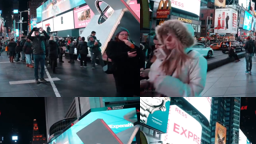

In [0]:
shift_down, shift_right, img_rolled = random_roll(np.array(resized_video[8]), 512)
show(img_rolled)

In [0]:
# for frame in resized_video:
#   print(frame.shape)

In [0]:
result = deepdreamed(resized_video)

In [0]:
HTML(display_(resized_video, result).to_html5_video())

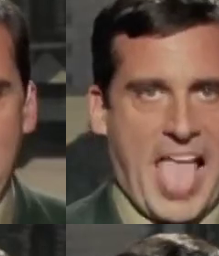

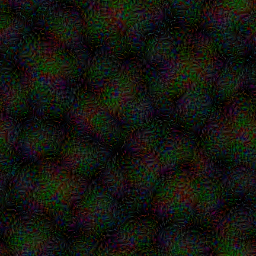

In [0]:
PIL.Image.fromarray(np.array(img))

In [0]:
url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg'

In [0]:
def download(url, max_dim=None):
  name = url.split('/')[-1]
  image_path = tf.keras.utils.get_file(name, origin=url)
  img = PIL.Image.open(image_path)
  if max_dim:
    img.thumbnail((max_dim, max_dim))
  return np.array(img)

In [0]:
original_img = download(url, max_dim=500)

90112/83281 [================================] - 0s 0us/step


In [0]:
original_img

array([[[160, 165,  99],
        [154, 159,  94],
        [151, 157,  93],
        ...,
        [137, 142,  84],
        [130, 135,  77],
        [126, 131,  71]],

       [[155, 160,  95],
        [154, 160,  95],
        [154, 160,  96],
        ...,
        [134, 141,  82],
        [136, 142,  84],
        [137, 144,  84]],

       [[149, 154,  90],
        [153, 159,  95],
        [155, 162,  98],
        ...,
        [135, 144,  84],
        [141, 149,  89],
        [143, 151,  91]],

       ...,

       [[103,  93,  57],
        [106, 100,  62],
        [ 84,  81,  42],
        ...,
        [117, 127,  67],
        [ 69,  79,   3],
        [112, 120,  37]],

       [[ 97,  82,  45],
        [110,  97,  61],
        [136, 127,  90],
        ...,
        [115, 122,  71],
        [ 72,  79,  11],
        [125, 129,  56]],

       [[163, 159, 126],
        [166, 163, 129],
        [150, 151, 114],
        ...,
        [119, 129,  45],
        [ 79,  81,  11],
        [118, 114,  57]]

In [0]:
video

[Array([[[83, 81, 77],
         [84, 82, 78],
         [84, 82, 78],
         ...,
         [41, 41, 41],
         [39, 39, 39],
         [39, 39, 39]],
 
        [[83, 81, 77],
         [83, 81, 77],
         [84, 82, 78],
         ...,
         [40, 40, 40],
         [38, 38, 38],
         [38, 38, 38]],
 
        [[83, 81, 77],
         [83, 81, 77],
         [83, 81, 77],
         ...,
         [39, 39, 39],
         [37, 37, 37],
         [36, 36, 36]],
 
        ...,
 
        [[63, 70, 63],
         [63, 70, 63],
         [64, 71, 64],
         ...,
         [36, 47, 36],
         [36, 47, 36],
         [36, 47, 36]],
 
        [[61, 68, 61],
         [61, 68, 61],
         [61, 68, 61],
         ...,
         [34, 45, 34],
         [34, 45, 34],
         [34, 45, 34]],
 
        [[60, 67, 60],
         [60, 67, 60],
         [60, 67, 60],
         ...,
         [33, 44, 33],
         [33, 44, 33],
         [33, 44, 33]]], dtype=uint8), Array([[[83, 81, 77],
         [84, 82, 78